**Problem statement:** Melanoma is a skin cancer that can be deadly if not treated early, because it has the ability to spread (metastasize) to other parts of the body.
    - It often starts as a mole or dark spot on the skin, with irregular borders. It may also itch, bleed, or crust over the skin. 
- The goal is to create a CNN model with TensorFlow that can detect it with the highest accuracy possible. 

In [1]:
# Import 
import pathlib  # For defining data path 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL  # to open and get Image's size
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob  # returns a list of file paths that match the given pattern. (E.g Get all .txt files in a directory)

- The dataset (10k images) can be downloaded from [Kaggle](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/data?select=melanoma_cancer_dataset).
- We have train and test data set (containing both Benign and Malignant Melanoma).
    - Benign Melanoma: Slow growing and can not be spread to other body parts. 
    - Malignant Melanoma: fast growing can be spread to other body parts. 

#### Step 1: Data understanding
- Set up file path
- Check no. of images
- Check shape

In [2]:
# Defining the path for train and test images (They are in the same path location as this .ipynb file)
data_train = pathlib.Path("train")
data_test = pathlib.Path("test")

In [3]:
# Check total amount of images
image_count_train = len(list(data_train.glob('*/*.jpg')))
print("Number of train images: ", image_count_train)
image_count_test = len(list(data_test.glob('*/*.jpg')))
print("Number of test images: ", image_count_test)

Number of train images:  9605
Number of test images:  1000


In [4]:
image = PIL.Image.open('train/malignant/melanoma_5000.jpg')

# Get the shape (width, height) of the image
width, height = image.size
print(f"Image shape: {width}x{height}")

Image shape: 300x300


#### Step 2: Data preprocessing
- Defining parameters for our dataset:
    - Training data
        - Model learns patterns, features, and relationships from this data by adjusting its internal weights using an optimization algorithm (such as gradient descent) based on the error (loss) between its predictions and the true labels.
        
    - Validation data
        - This is to tune the model during training, so that the model may see and process the data multiple times and adjust its weights accordingly to prevent overfitting.

    - Testing data
        - Model's prediction test on unseen data and evaluation is unbiased. 

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train,
    seed=123,  # random number
    validation_split=0.2,  # 20% will be used for training 
    subset='training',
    image_size=(width, height),  # To make sure that all images are 300x300 
    batch_size=128 # process 128 images at a time instead of 1,000 images all at once. 
)

Found 10605 files belonging to 2 classes.
Using 8484 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train,
    seed=123,
    validation_split = 0.2, # 20% will be used for validation 
    subset='validation',
    image_size=(width, height),
    batch_size=128)

Found 10605 files belonging to 2 classes.
Using 2121 files for validation.


In [7]:
# Finds all the classes of skin cancer from subdirectory, and stores them in a list.

class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


#### Step 3 : Data visualisation

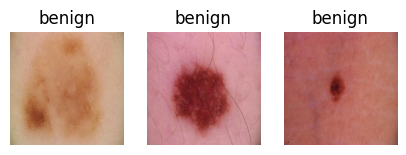

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)  #  Create a grid of smaller subplots (3x3) within a single figure (figure 5x5). *plt.subplot(r, c, index position)
        plt.imshow(images[i].numpy().astype("uint8")) # prints each image
        plt.title(class_names[labels[i]])
        plt.axis("off")

- `.astype("uint8")` converts the data type of the array (or image) to unsigned 8-bit integers.
    - Example: `image = [[0.4]]`, then after `.astype("uint8")` , it becomes `image = [[102]]`
    - This is important because image pixel values are usually represented in the **range 0 to 255**, which fits perfectly in the uint8 data type.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
cached_train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cached_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

- `AUTOTUNE` allows TensorFlow to automatically adjust the number of elements to prefetch based on the available CPU and other system resources to maximize efficiency. 
- `.cache()` stores the dataset in memory after it's first processed.
    - so that subsequent iterations through the dataset can access it directly from memory rather than reprocessing it from scratch.
    - This speeds up data access for future iterations. 

#### Step 4 : Model Building & training
- Create model using CNN and normilze it.
- Compile model with adam, loss function and accuracy.
- Train and test model.

In [10]:
## Using layers.Rescaling to normalize pixel values between (0,1)
num_classes = 2

model = Sequential([
  
  # Scale the pixcel values from [0, 255] to [0, 1] for faster convergence (normalization)
  layers.Rescaling(1./255, input_shape=(width, height, 3)),

  # Convolutional Layer 1: Appy 16 different 3x3 filters
  layers.Conv2D(16, (3, 3), padding='same', activation='relu'),  # relu(x) = max(0, x) where x > 0. 
  layers.MaxPooling2D(),

  # Convolutional Layer 2: Appy 32 different 3x3 filters
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),  # activation=tf.nn.relu
  layers.MaxPooling2D(),

  # Convolutional Layer 3: Appy 64 different 3x3 filters
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Converts 3D feature maps (layers 1,2,3) into 1D vector
  layers.Flatten(),

  # Fully Connected (Dense) Layer 1
  layers.Dense(128, activation='relu'),

  # Output Layer (for binary classification of Melanoma)
  layers.Dense(num_classes)
])

c:\Workflow\Python interpreter\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- `layers.Rescaling(1./255, ...)`: images [0 - 255] converts into [0,1] for model to **converge** (highest improvement found after no. of iterations) faster during training.

- `(3,3)` filter: It will look and apply kernel's weights at each 3x3 patch of pixels for 300x300 image.
    - The filter will slide over this image (300x300), processing each 3x3 patch of pixels at each position.

- `conv2D(16, (3,3))`: It will use 16 different 3x3 filters, each producing its own feature map. So output layer will have 16 channels. 
    - Feature map: learned features of the image after applying convolutional filters to an image.
- `padding='same'`: The output size of feature map is same as initial image (300x300).
    - If `padding='valid'` (no padding): The image will be smaller by 2 pixels (298x298) because filter (3x3) reduces spatial size by 2 pixels (1 pixel at top & bottom and 1 pixel for left & right)

- `layers.MaxPooling2D()`: Reduce the spatial dimensions (height and width) of the input feature map, but keep only the most important features.
    - This helps to reduce computational load, which speeds up learning progress.
    - This is **same** as `layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')`
        - `strides=2`: moves 2 pixels at each step



In [11]:
# Quick example of `padding = 'valid'` for image size of 5x5:

# Image of 5x5:
# [1, 1, 1, 1, 1]
# [1, 1, 1, 1, 1]
# [1, 1, 1, 1, 1]
# [1, 1, 1, 1, 1]
# [1, 1, 1, 1, 1]

# After Conv2D(16, (3, 3), padding='valid'):
# [1, 1, 1]
# [1, 1, 1]
# [1, 1, 1]


In [12]:
# How MaxPolling2D() works:
# If you don't give any specific parameter to it, then it will use the default which is 
# MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')

# [1, 3]
# [5, 7]

# Since max value here is 7, it will apply 7 to the new feature map. 

In [13]:
# Compile Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

- `optimizer='adam'`: Adaptive Moment Estimation (adam) adjusts learning rate for each parameter individually (for faster convergence). 

- `loss=tf.keras.losses....`: Loss function that measures how well model's predition matches true labels. 
    - `SparseCategoricalCrossentropy` (**cross-entropy loss**): Suited for multi-class classification (contains integers label like 1,2,3), not one-hot encoded (contains 0 or 1 only).
        - `CategoricalCrossentropy`: This is for one-hot encoded labels.

    - `from_logits=True`: Softmax will be applied to model's output after computing cross-entropy loss. 
        - If set to `False`, Softmax will not be applied.


- `metrics = ['accuracy']`: is calculated by $\frac{\text{Number of correct predictions}}{\text{Total number of predictions}}$



In [14]:
# View summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 300, 300, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,238,818 (42.87 MB)

 Trainable params: 11,238,818 (42.87 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train model:
history = model.fit(
  cached_train_ds,
  validation_data = cached_val_ds,
  epochs=20
)

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 0.7527 - loss: 0.6191 - val_accuracy: 0.7841 - val_loss: 0.4534
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 337ms/step - accuracy: 0.8782 - loss: 0.2908 - val_accuracy: 0.8831 - val_loss: 0.2643
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 337ms/step - accuracy: 0.8958 - loss: 0.2396 - val_accuracy: 0.8920 - val_loss: 0.2515
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 338ms/step - accuracy: 0.8989 - loss: 0.2395 - val_accuracy: 0.8892 - val_loss: 0.2532
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 338ms/step - accuracy: 0.9089 - loss: 0.2157 - val_accuracy: 0.8925 - val_loss: 0.2628
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 337ms/step - accuracy: 0.9188 - loss: 0.2022 - val_accuracy: 0.8958 - val_loss: 0.2486
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 337ms/step - accuracy: 0.9249 - loss: 0.1896 - val_accuracy: 0.9076 - val_loss: 0.2241
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 337ms/step - accuracy: 0.9329 - loss: 0.1678 - val_accu

- Wow, we got a 97.4% training accuracy.
- But since we got 91.5% validation accuracy, it means the model is abit overfit.

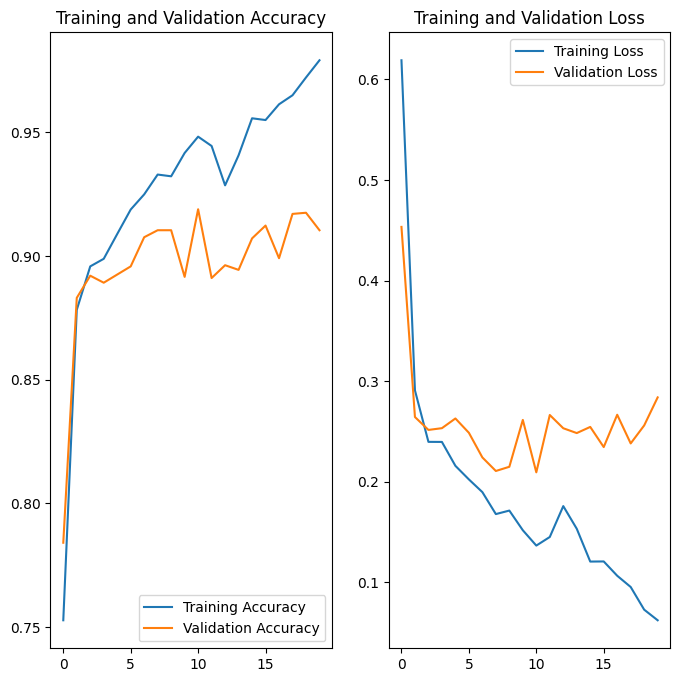

In [16]:
# Visualize this on graph:
epochs = 20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


##### Observation findings:
- **1st graph:** The model's training accuracy peeked at about 97.9%, while validation accuracy peeked at 91%.

- **2nd graph:** The train model has captured good amount of noise data (where training loss drop to 0.06), while validation model's loss plateaus around 0.28, which suggests that the model have stopped generalizing well to unseen data, because it has memorized (overfit) too much on the noise and specific details in the training data.

- These observations confirm the **presence of overfitting**. 
- **Solution:** Utilize the appropriate data augmentation strategy to resolve overfitting.
    - Data Augmentation includes applying transformations to images:
        - Rotation: Rotating images by a random angle.
        - Zooming: Randomly zooming in on the image.
        - Flipping: Randomly flipping images horizontally or vertically.
        - Brightness: Adjusting the brightness of the images.
        - Shearing: Applying shearing transformations to the images.
        - Shifting: Translating images horizontally or vertically.

#### Step 5: Choose the best data augmentation strategy

In [17]:
data_augmentation = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(height, width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

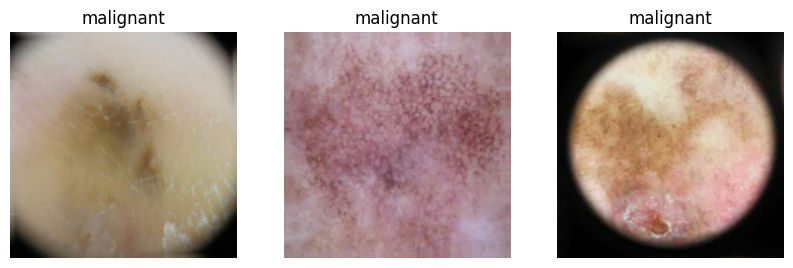

In [18]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))

for images, labels in cached_train_ds.take(1):
  for i in range(3):
    augmented_image = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### Step 6: Apply data augmentation to model

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),

  # Layer 1
  layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Layer 2
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Layer 3
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),


  layers.Dropout(0.2), # drop 20% of neurons to prevent model from relaying too much on specific neurons (prevent overfitting)
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
## Train model (epochs = 20)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 31s 447ms/step - accuracy: 0.7185 - loss: 0.7369 - val_accuracy: 0.7921 - val_loss: 0.4648
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 444ms/step - accuracy: 0.8511 - loss: 0.3428 - val_accuracy: 0.8675 - val_loss: 0.3015
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 443ms/step - accuracy: 0.8686 - loss: 0.3052 - val_accuracy: 0.8826 - val_loss: 0.2758
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 443ms/step - accuracy: 0.8766 - loss: 0.2948 - val_accuracy: 0.8543 - val_loss: 0.3660
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 443ms/step - accuracy: 0.8728 - loss: 0.2927 - val_accuracy: 0.8878 - val_loss: 0.2708
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 444ms/step - accuracy: 0.8846 - loss: 0.2717 - val_accuracy: 0.8868 - val_loss: 0.2673
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 443ms/step - accuracy: 0.8903 - loss: 0.2611 - val_accuracy: 0.8897 - val_loss: 0.2597
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 443ms/step - accuracy: 0.8885 - loss: 0.2610 - val_accu

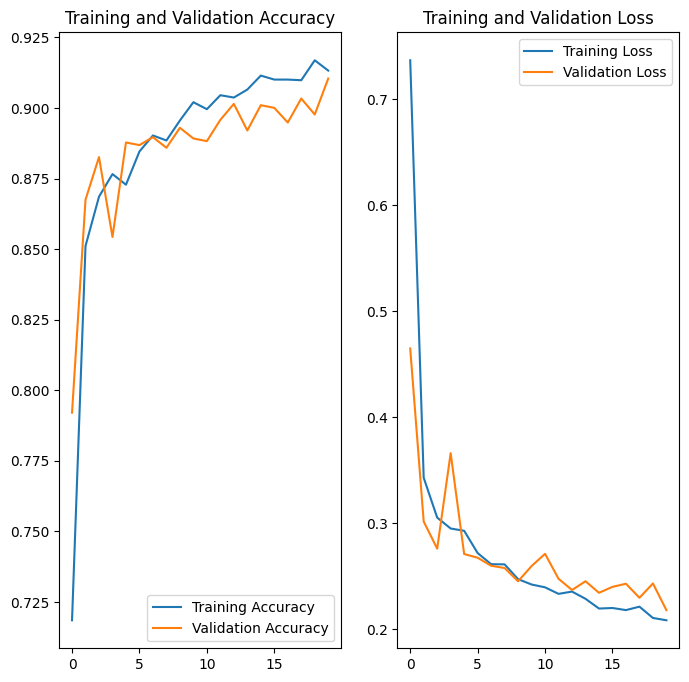

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Observation findings:
- **1st graph:** The model's training accuracy peeked at about 91.3%, while validation accuracy peeked at 91%. The close alignment between training and validation curves indicates controlled generalization where it is not overfitting nor underfitting. 

- **2nd graph:** Both train and validation model has captured good amount of noise data (where training loss converge around 0.21 - 0.2). This indicates worse perfomance than previous experiment, where training loss was at 0.06. This reflects reduced memorization rather than degraded performance.

- So Overall: The small train–validation gap and consistent loss curves indicate the model has reached a balanced bias–variance trade-off. The training performance appears **capacity-limited** rather than optimization failure. This could be caused by model complexity, data quality, or inherent class ambiguity.

- These observations confirm the **presence of data capacity limitation**. 
- **Solution:** Class distribution (to fit class imbalance)
    - In a imbalanced dataset, one class (benign or malignant melanoma) might have far more examples than the other, leading the model to focus on predicting the majority class most of the time. This can lead to misleading evaluation metrics in accuracy. 


#### Step 7: Check on Class Distribution and handle any imbalances

In [23]:
# Check the distribution of the class:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image, label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)
# Adjustments
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
print(count)

benign       4385
malignant    4099
Name: count, dtype: int64


C:\Users\Zen7\AppData\Local\Temp\ipykernel_13940\2162607067.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Lesion Type', x='No. of Images', data=df, palette='Set2')


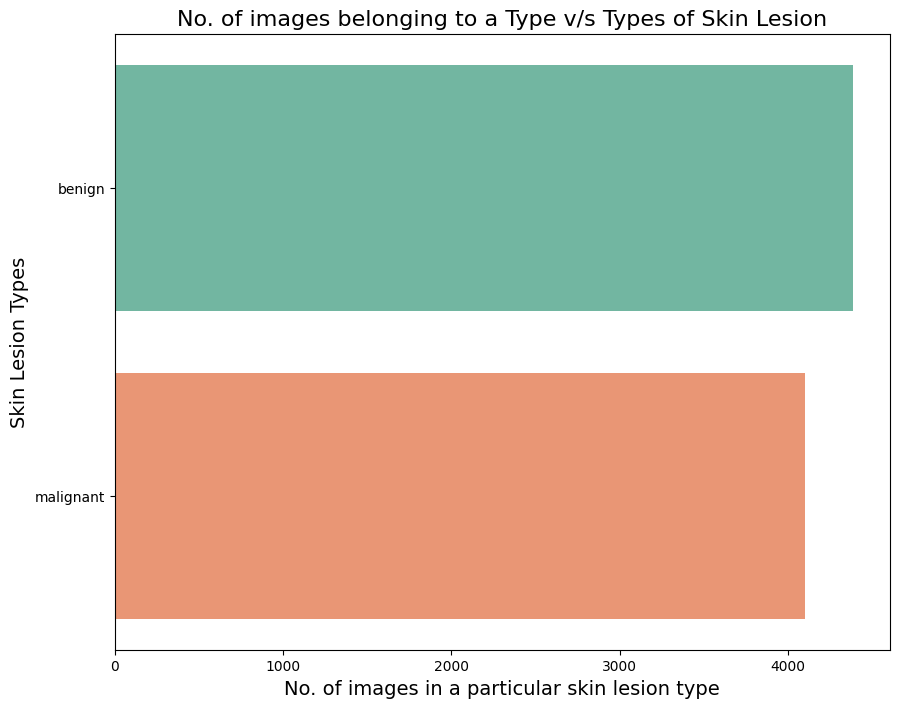

In [24]:
# Visualize the distribution of classes using a barplot
import seaborn as sns

plt.figure(figsize=(10, 8))
df = pd.DataFrame({'Lesion Type': count.index, 'No. of Images': count.values})
sns.barplot(y='Lesion Type', x='No. of Images', data=df, palette='Set2')
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

- Class malignant has the least number of smaples which is 4099.
- Solution: we add more malignant samples to have almost equal amount of skin types. 
    - We can install and use [Augmentor](https://augmentor.readthedocs.io/en/master/) to add them.

In [25]:
!pip install Augmentor

In [26]:

import Augmentor
for i in class_names:
    # Instantiate a pipeline object
    p = Augmentor.Pipeline(str(data_train) + '/' + str(i))

    # Define operations to perform on dataset
    # rotate image randomly by a probability of 70% with rotation of -10 to +10 degree
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Execute operation by applying rotation and generating 500 augmentaed samples for each class 
    p.sample(500) 

Initialised with 5000 image(s) found.
Output directory set to train/benign\output.

Processing <PIL.Image.Image image mode=RGB size=300x300 at 0x1EE1540F390>: 100%|██████████| 500/500 [00:00<00:00, 1334.47 Samples/s]                 


Initialised with 4605 image(s) found.
Output directory set to train/malignant\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x300 at 0x1EE154DC640>: 100%|██████████| 500/500 [00:00<00:00, 1316.00 Samples/s]


In [27]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_train.glob('*/output/*.jpg')))
print(image_count_train)

2000


- 500 sample images of malignant.
- 500 sample images of benign.
- Now that we have balance data, we can build and train our model

#### Step 8: Build and train model after fixing class imbalance

In [28]:
# Create training dataset
data_train=pathlib.Path("train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split = 0.2, 
  subset = "training",
  image_size=(height, width),
  batch_size=128)

Found 11605 files belonging to 2 classes.
Using 9284 files for training.


In [29]:
# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(height, width),
  batch_size=128)

Found 11605 files belonging to 2 classes.
Using 2321 files for validation.


In [30]:
## Build model
model = Sequential([
    data_augmentation,
    # normalization
    layers.Rescaling(1./255),

    # layer 1
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # layer 2
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # layer 3
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [31]:
## Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs # 30
)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 36s 466ms/step - accuracy: 0.7439 - loss: 0.6627 - val_accuracy: 0.8479 - val_loss: 0.3571
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 436ms/step - accuracy: 0.8463 - loss: 0.3508 - val_accuracy: 0.8690 - val_loss: 0.3168
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 435ms/step - accuracy: 0.8742 - loss: 0.3043 - val_accuracy: 0.8651 - val_loss: 0.3343
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 435ms/step - accuracy: 0.8786 - loss: 0.2943 - val_accuracy: 0.8785 - val_loss: 0.2873
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.8817 - loss: 0.2828 - val_accuracy: 0.8695 - val_loss: 0.3097
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 442ms/step - accuracy: 0.8815 - loss: 0.2834 - val_accuracy: 0.8626 - val_loss: 0.3059
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 439ms/step - accuracy: 0.8837 - loss: 0.2772 - val_accuracy: 0.8746 - val_loss: 0.2749
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 436ms/step - accuracy: 0.8883 - loss: 0.2685 - val_accu

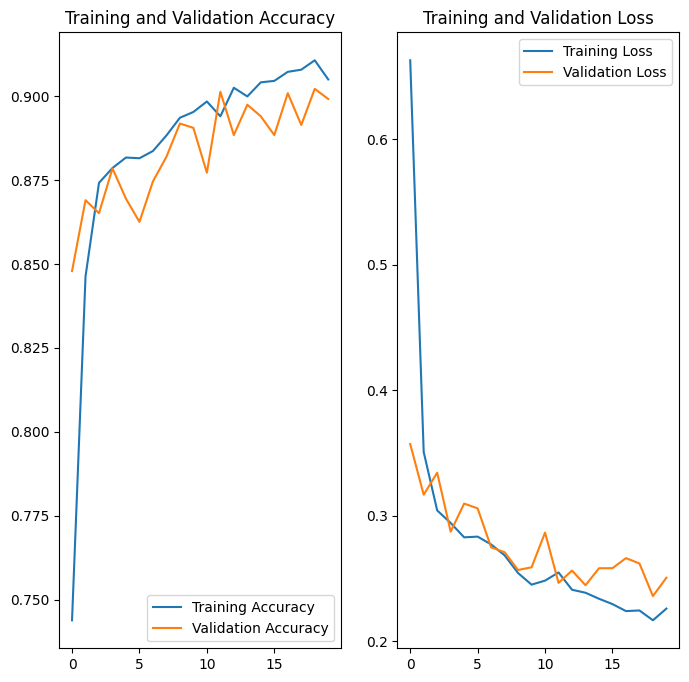

In [33]:
# Visualize Model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Observation findings:
- **1st graph:** The model's training accuracy peeked at about 90.5%, while validation accuracy peeked at 89.9%.

- **2nd graph:** The train model has captured good amount of noise data (where training loss drop to 0.22), while validation model's loss plateaus around 0.25. 

- These observations confirm that the model displayed a **well-balnaced performance**, with no clear signs of overfitting or underfitting. 
    - Furthermore, the small gap between training and validation loss and accuracy implies that the model is **learning general** **patterns efficiency** without overfitting to noise.

#### Final step: Model Evaulation
- Testing model's accuracy and prediction on unseen dataset.

In [34]:
# Finding Model's accuracy on unseen data set:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_test,
                                                                    image_size=(300, 300),  
                                                                    batch_size=128,
                                                                    shuffle=False)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

Found 1000 files belonging to 2 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9100 - loss: 0.2238
Test loss: 0.22379018366336823, Test accuracy: 0.9100000262260437


- In conclusion: CNN Model's accuracy is at **91%** at detecting melanoma. 

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

for className in class_names:
  # Construct the path to the images
  test_image_dir = os.path.join(data_test, className, '*')
  test_images = glob(test_image_dir)

  for i in test_images:
    # Load the image and resize it
    image = load_img(i, target_size=(300, 300))

    # Convert the image to numpy array and add an extra dimension for batch size
    img = np.expand_dims(np.array(image), axis=0)

    # Make a prediction
    pred = model.predict(img)
    pred = np.argmax(pred)

    # Get the predicted class name
    pred_class = class_names[pred]

    # Print the actual and predicted classes
    print(f"Actual Class: {className}\nPredicted Class: {pred_class}")

    # Uncomment this to Display the image (use loaded image) for each test
    # plt.imshow(image)
    # plt.show()  # Show the image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Actual Class: benign
Predicted Class: benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: benign
Predicted Class: benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Actual Class: benign
Predicted Class: benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Actual Class: benign
Predicted Class: benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: benign
Predicted Class: benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: benign
Predicted Class: benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual Class: benign
Predicted Class: malignant
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Actual Class: benign
Predicted Class: malignant
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual Class: benign
Predicted Class: malignant
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: benign
Predicted Class: benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: benign
Predicted Class: benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Actual Class: benign
Predicted Class: be